In [148]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [211]:
df = pd.read_csv('./csv/travistorrent_8_2_2017.csv')

C:\Users\norouziy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3,6,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [212]:
df = df[['gh_pushed_at', 'gh_first_commit_created_at', 'tr_status', 'git_diff_src_churn', 'git_diff_test_churn', 'gh_sloc', 'gh_lang', 'gh_team_size', 'tr_build_id', 'tr_log_num_tests_run', 'tr_log_num_tests_ok', 'tr_log_num_tests_failed', 'gh_test_lines_per_kloc', 'gh_project_name']]

In [213]:
df.dtypes

gh_pushed_at                   object
gh_first_commit_created_at     object
tr_status                      object
git_diff_src_churn              int64
git_diff_test_churn             int64
gh_sloc                         int64
gh_lang                        object
gh_team_size                    int64
tr_build_id                     int64
tr_log_num_tests_run          float64
tr_log_num_tests_ok           float64
tr_log_num_tests_failed       float64
gh_test_lines_per_kloc        float64
gh_project_name                object
dtype: object

In [215]:
df = df.loc[df['gh_team_size'] < 60]

In [216]:
# Convert gh_pushed_at and gh_first_commit_created_at to delta time
df['gh_pushed_at'] = pd.to_datetime(df['gh_pushed_at'])
df['gh_first_commit_created_at'] = pd.to_datetime(df['gh_first_commit_created_at'])

In [217]:
# Get date diff from them
df['date_diff'] = df['gh_pushed_at'].sub(df['gh_first_commit_created_at'], axis=0)
df["date_diff"] = df["date_diff"] / np.timedelta64(1, 'm')

In [218]:
# Dropping rows where travis status is canceled or started and mapping the rest to 0 and 1
df = df[df.tr_status != 'canceled']
df = df[df.tr_status != 'started']
df['tr_status'] = df['tr_status'].map({'passed': 1, 'failed': 0, 'errored': 0})

In [219]:
# Source and test code ratio and their ratio over time
df["src_diff_ratio"] = df["git_diff_src_churn"] / df["gh_sloc"]
df["src_date"] = df["src_diff_ratio"] / df["date_diff"]
df["test_diff_ratio"] = df["git_diff_test_churn"] / df["gh_test_lines_per_kloc"] * df["gh_sloc"]
df["test_date"] = df["test_diff_ratio"] / df["date_diff"]

In [220]:
df.replace('', np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [221]:
df = df[pd.notnull(df['tr_log_num_tests_run'])]

In [222]:
df = df[pd.notnull(df['tr_log_num_tests_ok'])]

In [223]:
df = df[pd.notnull(df['tr_log_num_tests_failed'])]

In [224]:
df.shape

(1550252, 19)

In [225]:
df.groupby('gh_team_size').gh_project_name.nunique()

gh_team_size
0      16
1     153
2     358
3     396
4     386
5     374
6     330
7     289
8     242
9     214
10    177
11    165
12    141
13    122
14     99
15     86
16     73
17     68
18     63
19     56
20     45
21     49
22     42
23     40
24     35
25     37
26     38
27     31
28     28
29     28
30     28
31     22
32     24
33     21
34     26
35     23
36     22
37     19
38     20
39     20
40     14
41     17
42     16
43     15
44     14
45     13
46     13
47     11
48     11
49      9
50      9
51      7
52      8
53      7
54      6
55      6
56      4
57      5
58      4
59      4
Name: gh_project_name, dtype: int64

In [226]:
df = df.sort_values('gh_team_size')
team_size = df.gh_team_size.unique()

In [227]:
df.to_csv('./csv/refined.csv')

In [228]:
src = np.array(df.groupby('gh_team_size', as_index=False)['git_diff_src_churn'].mean()['git_diff_src_churn'].tolist(), dtype=np.float)
test = np.array(df.groupby('gh_team_size', as_index=False)['git_diff_test_churn'].mean()['git_diff_test_churn'].tolist(), dtype=np.float)
t_sloc = np.array(df.groupby('gh_team_size', as_index=False)['gh_test_lines_per_kloc'].mean()['gh_test_lines_per_kloc'].tolist(), dtype=np.float)
sloc = np.array(df.groupby('gh_team_size', as_index=False)['gh_sloc'].mean()['gh_sloc'].tolist(), dtype=np.float)

In [229]:
stats.spearmanr(team_size, src)
# no correlation

SpearmanrResult(correlation=0.133148096693526, pvalue=0.3104923297831414)

In [230]:
stats.spearmanr(team_size, test)
# no correlation

SpearmanrResult(correlation=0.2397888302306197, pvalue=0.06498699549522383)

In [231]:
stats.spearmanr(team_size, sloc)
# correlation

SpearmanrResult(correlation=0.8252292303417618, pvalue=5.107997705410572e-16)

In [232]:
stats.spearmanr(team_size, t_sloc * sloc)
# correlation

SpearmanrResult(correlation=0.7658238399555433, pvalue=1.0173499382451032e-12)

In [233]:
stats.spearmanr(team_size, test/t_sloc * sloc)
# correlation

SpearmanrResult(correlation=0.7881633787163103, pvalue=7.785134932365775e-14)

In [234]:
stats.spearmanr(team_size, src/sloc)
# correlation

SpearmanrResult(correlation=-0.908585718255071, pvalue=1.170892904045847e-23)

In [235]:
# tests
failed_tests = np.array(df.groupby('gh_team_size', as_index=False)['tr_log_num_tests_failed'].mean()['tr_log_num_tests_failed'].tolist(), dtype=np.float)
ok_tests = np.array(df.groupby('gh_team_size', as_index=False)['tr_log_num_tests_ok'].mean()['tr_log_num_tests_ok'].tolist(), dtype=np.float)
run_tests = np.array(df.groupby('gh_team_size', as_index=False)['tr_log_num_tests_run'].mean()['tr_log_num_tests_run'].tolist(), dtype=np.float)

In [236]:
stats.spearmanr(team_size, failed_tests)
# No correlation

SpearmanrResult(correlation=-0.21155876632397896, pvalue=0.10465778667705211)

In [237]:
stats.spearmanr(team_size, ok_tests)
# no correlation

SpearmanrResult(correlation=0.4829119199777717, pvalue=9.309902719188377e-05)

In [238]:
stats.spearmanr(team_size, run_tests)
# no correlation

SpearmanrResult(correlation=0.4829119199777717, pvalue=9.309902719188377e-05)

In [239]:
stats.spearmanr(team_size, failed_tests/run_tests)
# no correlation

SpearmanrResult(correlation=-0.38694081689358156, pvalue=0.002257321682964328)

In [240]:
stats.spearmanr(team_size, ok_tests/run_tests)
# no correlation

SpearmanrResult(correlation=0.38694081689358156, pvalue=0.002257321682964328)

In [241]:
# date
date_diff = np.array(df.groupby('gh_team_size', as_index=False)['date_diff'].mean()['date_diff'].tolist(), dtype=np.float)
src_date = np.array(df.groupby('gh_team_size', as_index=False)['src_date'].mean()['src_date'].tolist(), dtype=np.float)
test_date = np.array(df.groupby('gh_team_size', as_index=False)['test_date'].mean()['test_date'].tolist(), dtype=np.float)

In [242]:
stats.spearmanr(team_size, date_diff)
# no correlation

SpearmanrResult(correlation=-0.33681578216171165, pvalue=0.008502020262837966)

In [245]:
stats.spearmanr(team_size, src_date)
# no correlation

SpearmanrResult(correlation=-0.7769380383439847, pvalue=2.9388017605642834e-13)

In [244]:
stats.spearmanr(team_size, test_date)
# no correlation

SpearmanrResult(correlation=-0.21894970825229232, pvalue=0.09280916981005517)

In [246]:
# Travis status
counts = df.groupby(['gh_team_size']).size().reset_index(name='counts')
failed = np.array(df.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 0].tolist(), dtype=np.float)
passed = np.array(df.groupby(['gh_team_size']).tr_status.value_counts().unstack(fill_value=0).loc[:, 1].tolist(), dtype=np.float)
total_status = np.array(list(counts['counts']), dtype=np.float)

In [247]:
stats.spearmanr(team_size, failed/total_status)
# no correlation

SpearmanrResult(correlation=0.574103917754932, pvalue=1.6197959566216812e-06)

In [248]:
stats.spearmanr(team_size, passed/total_status)
# no correlation

SpearmanrResult(correlation=-0.574103917754932, pvalue=1.6197959566216812e-06)

In [249]:
stats.mannwhitneyu(team_size, src)

MannwhitneyuResult(statistic=163.0, pvalue=4.3713312734194635e-18)

In [250]:
stats.mannwhitneyu(team_size, failed/total_status)

MannwhitneyuResult(statistic=60.0, pvalue=3.424736600788257e-20)

In [251]:
stats.wilcoxon(team_size, failed/total_status)

WilcoxonResult(statistic=1.0, pvalue=1.7141493981716166e-11)

In [252]:
stats.ranksums(team_size, failed/total_status)

RanksumsResult(statistic=9.132631530817717, pvalue=6.685408805976295e-20)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e30b0c5c88>,
 'caps': [<matplotlib.lines.Line2D at 0x1e34844c0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e30b0c5b00>,
 'medians': [<matplotlib.lines.Line2D at 0x1e34844c278>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e34844cac8>,
 'means': []}

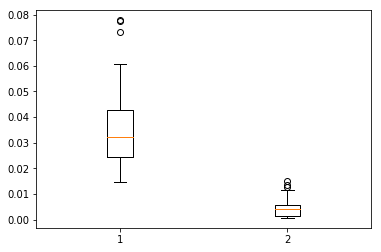

In [253]:
data_to_plot = [test/t_sloc, src/sloc]
plt.boxplot(data_to_plot)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e32df6b390>,
 'caps': [<matplotlib.lines.Line2D at 0x1e32df6b0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e32df6b4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x1e33cf57550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e33cf575f8>],
 'means': []}

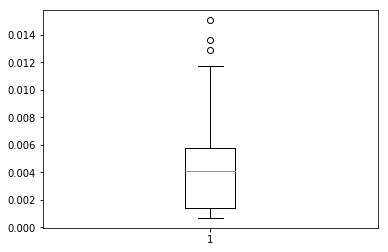

In [254]:
plt.boxplot(src/sloc)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e39dac3630>,
 'caps': [<matplotlib.lines.Line2D at 0x1e39daac668>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e39dac3240>],
 'medians': [<matplotlib.lines.Line2D at 0x1e39daac780>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e39daaceb8>],
 'means': []}

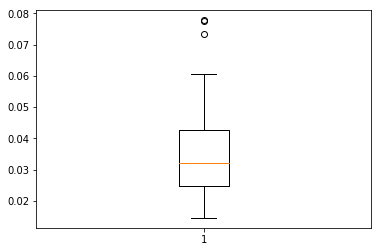

In [255]:
plt.boxplot(test/t_sloc)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e31405c3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1e32cc8b048>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e31405cef0>,
 'medians': [<matplotlib.lines.Line2D at 0x1e32cc8bd30>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e32cc8bba8>,
 'means': []}

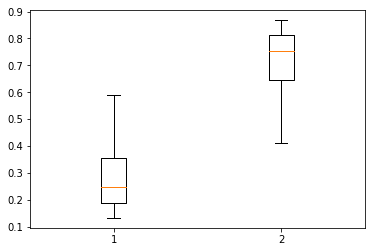

In [256]:
data_to_plot = [failed/total_status, passed/total_status]
plt.boxplot(data_to_plot)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e336cbc198>,
 'caps': [<matplotlib.lines.Line2D at 0x1e336cbcb38>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e336cbc588>],
 'medians': [<matplotlib.lines.Line2D at 0x1e3255fae10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e3255fa0f0>],
 'means': []}

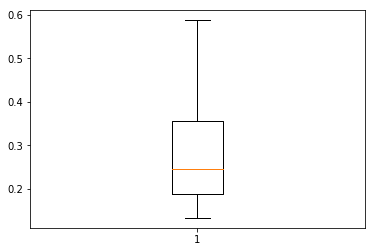

In [257]:
plt.boxplot(failed/total_status)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e33e1f3dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x1e33e1f1a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e33e1f3160>],
 'medians': [<matplotlib.lines.Line2D at 0x1e33e1f1048>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e3255ed0b8>],
 'means': []}

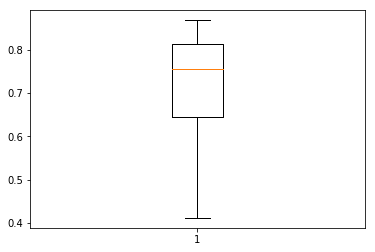

In [258]:
plt.boxplot(passed/total_status)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e326986160>,
 'caps': [<matplotlib.lines.Line2D at 0x1e357b91a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e3269865f8>,
 'medians': [<matplotlib.lines.Line2D at 0x1e357b91390>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e357b912b0>,
 'means': []}

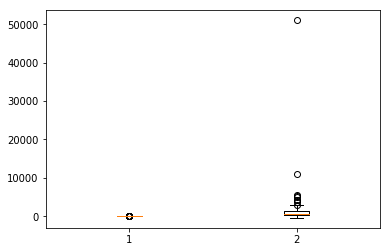

In [265]:
data_to_plot = [src_date, test_date]
plt.boxplot(data_to_plot)
# not useful

{'whiskers': [<matplotlib.lines.Line2D at 0x1e328ebe518>,
 'caps': [<matplotlib.lines.Line2D at 0x1e328ebe1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e328ebe400>],
 'medians': [<matplotlib.lines.Line2D at 0x1e38e439ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e38e439e48>],
 'means': []}

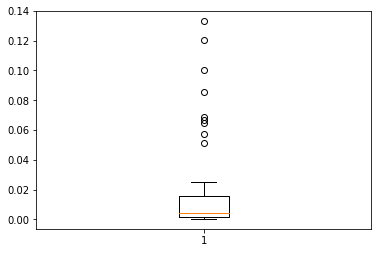

In [264]:
plt.boxplot(src_date)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e312aea438>,
 'caps': [<matplotlib.lines.Line2D at 0x1e339493550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e312aea4e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e33e375c18>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e32b70bf60>],
 'means': []}

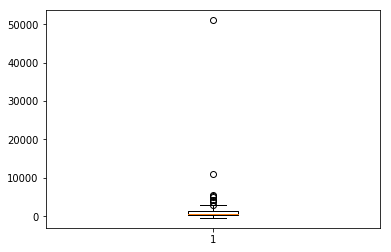

In [263]:
plt.boxplot(test_date)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e32cc6b358>,
 'caps': [<matplotlib.lines.Line2D at 0x1e32cc6bf28>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e32cc6bc18>],
 'medians': [<matplotlib.lines.Line2D at 0x1e348452748>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e3484529e8>],
 'means': []}

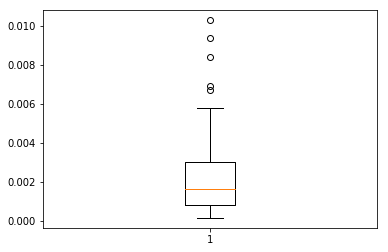

In [266]:
plt.boxplot(failed_tests/run_tests)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e3873f5518>,
 'caps': [<matplotlib.lines.Line2D at 0x1e3873f5cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e3886bd550>],
 'medians': [<matplotlib.lines.Line2D at 0x1e3873f5240>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e387202b70>],
 'means': []}

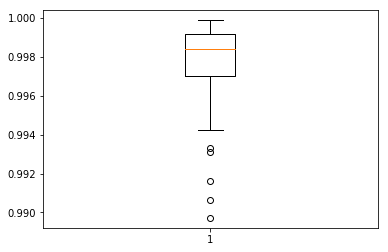

In [267]:
plt.boxplot(ok_tests/run_tests)

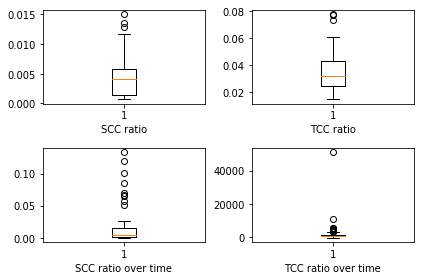

In [270]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].boxplot(src/sloc)
ax[0, 1].boxplot(test/t_sloc)
ax[1, 0].boxplot(src_date)
ax[1, 1].boxplot(test_date)

ax[0, 0].set_xlabel('SCC ratio')
ax[0, 1].set_xlabel('TCC ratio')
ax[1, 0].set_xlabel('SCC ratio over time')
ax[1, 1].set_xlabel('TCC ratio over time')

plt.tight_layout(w_pad=0.5, h_pad=1.0)
plt.savefig('./fig4/code_dist.png', dpi=1000)
plt.show()

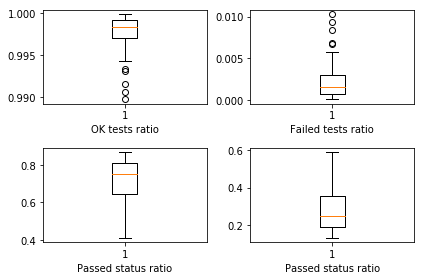

In [271]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].boxplot(ok_tests/run_tests)
ax[0, 1].boxplot(failed_tests/run_tests)
ax[1, 0].boxplot(passed/total_status)
ax[1, 1].boxplot(failed/total_status)

ax[0, 0].set_xlabel('OK tests ratio')
ax[0, 1].set_xlabel('Failed tests ratio')
ax[1, 0].set_xlabel('Passed status ratio')
ax[1, 1].set_xlabel('Passed status ratio')
plt.tight_layout(w_pad=0.5, h_pad=1.0)
plt.savefig('./fig4/rest_dist.png', dpi=1000)
plt.show()